In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import matplotlib
import itertools

In [294]:
def make_mesh_and_sol(n_nodes=10):
    coords_nodes = 2 * np.random.rand(n_nodes, 2) - 1
    corners = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
    coords_nodes = np.concatenate([coords_nodes, corners])

    def func(x, y):
        return np.sin(np.pi*x) + np.cos(np.pi*y)

    values_nodes = func(coords_nodes[:, 0], coords_nodes[:, 1])
    
    mesh = Delaunay(coords_nodes)

    return mesh, values_nodes


make_mesh_and_sol(10)[0].points.shape, make_mesh_and_sol(10)[1].shape

((14, 2), (14,))

In [295]:
def make_grid(n_grid = 10):
    grid_points = np.linspace(-1, 1, n_grid)
    x_grid, y_grid = np.meshgrid(grid_points, grid_points)
    
    grid = np.hstack([x_grid.flatten()[:, None], y_grid.flatten()[:, None]])

    return x_grid, y_grid, grid


make_grid()[0].shape, make_grid()[1].shape, make_grid()[2].shape

((10, 10), (10, 10), (100, 2))

In [296]:
def shape_func(coord, el_coords):
    x1 = el_coords[0][0]; y1 = el_coords[0][1]
    x2 = el_coords[1][0]; y2 = el_coords[1][1]
    x3 = el_coords[2][0]; y3 = el_coords[2][1]
    
    a0 = x1; b0 = y1
    a1 = x2 - x1; b1 = y2 - y1
    a2 = x3 - x1; b2 = y3 - y1
    
    xhat = coord[0]; yhat = coord[1]
    
    etahat = (a1*yhat - b1*xhat + b1*a0 - a1*b0) / (a1*b2 - a2*b1)
    xihat = (xhat - a0 - a2*etahat) / a1
        
    n1 = 1 - xihat - etahat
    n2 = xihat
    n3 = etahat
    
    n = np.array([n1, n2, n3])
    
    return n


el_coords = np.array([[0, 0], [1, 0], [0, 1]])
x = [0, 0]

shape_func(x, el_coords)

array([1., 0., 0.])

In [297]:
mesh, value_nodes = make_mesh_and_sol(100)

In [303]:
x_grid, y_grid, grid = make_grid(10)

In [304]:
from pprint import pprint

def find_grids_in_each_element(grid, mesh):
    point_to_element = mesh.find_simplex(grid)
    elements = np.unique(point_to_element)

    element_to_point = [None for e in range(len(mesh.simplices))]

    for eid in range(len(element_to_point)):
        element_to_point[eid] = np.where(point_to_element==eid)[0]
    
    return element_to_point
 

sum(len(f) for f in find_grids_in_each_element(grid, mesh))

100

In [322]:
def plot_mesh_value_grid(mesh, values_nodes, ax, x_grid=None, y_grid=None):
    triangulation = matplotlib.tri.Triangulation(mesh.points[:, 0], mesh.points[:, 1], mesh.simplices)

    ax_cont = ax.tricontourf(triangulation, values_nodes);
    ax.triplot(triangulation, color='b', linewidth=1, alpha=0.5);
    # if x_grid is not None and y_grid is not None:
    #     ax.scatter(x_grid, y_grid, color='r', s=0.1)
        
    return ax_cont


def plot_grid_value(x_grid, y_grid, grid_values, ax):
    ax_cont = ax.contourf(x_grid, y_grid, grid_values.reshape(*y_grid.shape))
    ax.scatter(x_grid, y_grid, color='r', s=10)
    return ax_cont

In [323]:
elements_grids_nums = find_grids_in_each_element(grid, mesh)

grid_values = [None for g in range(len(grid))]

for e, grid_nums in enumerate(elements_grids_nums):
    el_nodes = mesh.simplices[e]
    el_coords = mesh.points[el_nodes]
    el_values = value_nodes[el_nodes]
    
    for grid_num in grid_nums:
        grid_coord = grid[grid_num]
        n = shape_func(grid_coord, el_coords)
        grid_value = n.dot(el_values)

        grid_values[grid_num] = grid_value
              
grid_values = np.array(grid_values)

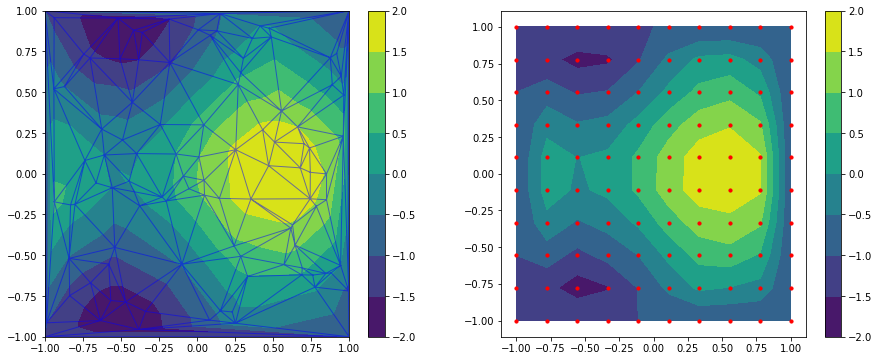

In [324]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6))
ax_cont1 = plot_mesh_value_grid(mesh, value_nodes, ax0, x_grid, y_grid)
ax_cont2 = plot_grid_value(x_grid, y_grid, grid_values, ax1)
fig.colorbar(ax_cont1, ax=ax0)
fig.colorbar(ax_cont2, ax=ax1)